In [ ]:
# the fit algorithm needs to predict
# heteroscedastic uncertainty

In [ ]:
# https://tinygp.readthedocs.io/en/stable/tutorials/modeling.html

In [ ]:
# https://docs.gpytorch.ai/en/latest/likelihoods.html#fixednoisegaussianlikelihood

In [ ]:
# best description here of aleatoric and epistemic uncertainty
# https://gpflow.github.io/GPflow/develop/notebooks/getting_started/basic_usage.html

In [ ]:
# use 2 GPs to model heteroscedastic uncertainty
# https://gpflow.github.io/GPflow/develop/notebooks/advanced/heteroskedastic.html#Standard-(Homoskedastic)-Regression

In [ ]:
# pymc
# https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Heteroskedastic.html

In [ ]:
# https://www.dominodatalab.com/blog/fitting-gaussian-process-models-python

# tinygp example

In [ ]:
# https://tinygp.readthedocs.io/en/stable/tutorials/modeling.html

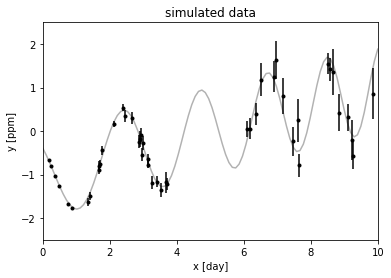

In [11]:
import numpy as np
import matplotlib.pyplot as plt

random = np.random.default_rng(42)

t = np.sort(
    np.append(
        random.uniform(0, 3.8, 28),
        random.uniform(5.5, 10, 18),
    )
)
yerr = random.uniform(0.08, 0.22, len(t)) * t/3
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * random.normal(size=len(t))
)

true_t = np.linspace(0, 10, 100)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

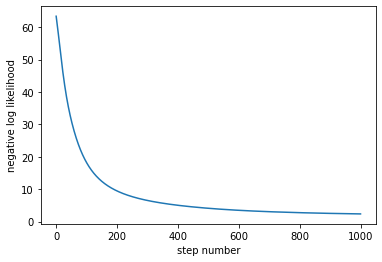

In [12]:
from tinygp import kernels, GaussianProcess

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.linen.initializers import zeros

import optax


class GPModule(nn.Module):
    @nn.compact
    def __call__(self, x, yerr, y, t):
        mean = self.param("mean", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())

        log_sigma1 = self.param("log_sigma1", zeros, ())
        log_rho1 = self.param("log_rho1", zeros, ())
        log_tau = self.param("log_tau", zeros, ())
        kernel1 = (
            jnp.exp(2 * log_sigma1)
            * kernels.ExpSquared(jnp.exp(log_tau))
            * kernels.Cosine(jnp.exp(log_rho1))
        )

        log_sigma2 = self.param("log_sigma2", zeros, ())
        log_rho2 = self.param("log_rho2", zeros, ())
        kernel2 = jnp.exp(2 * log_sigma2) * kernels.Matern32(jnp.exp(log_rho2))

        kernel = kernel1 + kernel2
        gp = GaussianProcess(
            kernel, x, diag=yerr**2 + jnp.exp(log_jitter), mean=mean
        )

        log_prob, gp_cond = gp.condition(y, t)
        return -log_prob, gp_cond.loc


def loss(params):
    return model.apply(params, t, yerr, y, true_t)[0]


model = GPModule()
params = model.init(jax.random.PRNGKey(0), t, yerr, y, true_t)
tx = optax.sgd(learning_rate=3e-3)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

losses = []
for i in range(1001):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")

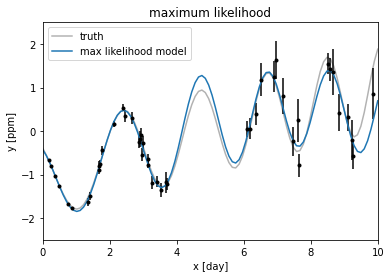

In [13]:
pred = model.apply(params, t, yerr, y, true_t)[1]

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(true_t, pred, label="max likelihood model")
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")

# try this

In [ ]:
# https://tinygp.readthedocs.io/en/stable/tutorials/intro.html

In [60]:
# Simulate a made up dataset, as an example
random = np.random.default_rng(1)
X = np.sort(random.uniform(0, 10, 10))


# yerr = random.uniform(0.08, 0.22, len(t)) * t/3
# y = (
#     0.2 * (t - 5)
#     + np.sin(3 * t + 0.1 * (t - 5) ** 2)
#     + yerr * random.normal(size=len(t))
# )

# yerr = 1e-4
yerr = random.uniform(0.08, 0.22, len(X)) * X/5
y = np.sin(X) + yerr * random.normal(size=X.shape)

# Compute the log probability
kernel = 0.5 * kernels.ExpSquared(scale=1.0)
gp = GaussianProcess(kernel, X, diag=yerr**2)
print(gp.log_probability(y))

-7.8026686


<ErrorbarContainer object of 3 artists>

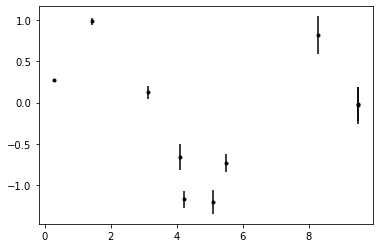

In [61]:
plt.errorbar(X, y, yerr=yerr, fmt=".k", label="data")

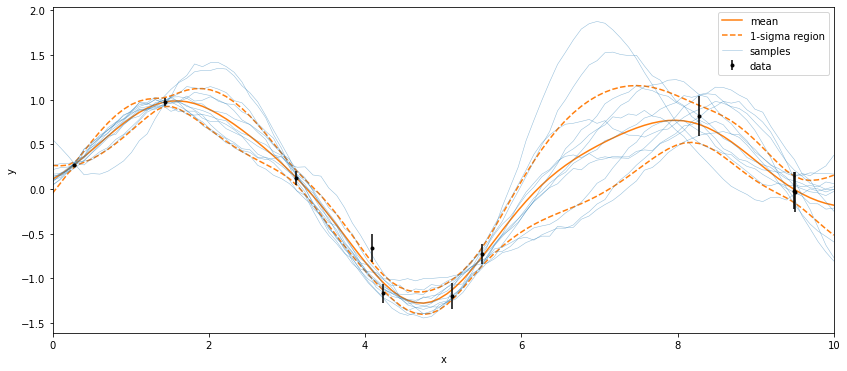

In [62]:
X_test = np.linspace(0, 10, 100)
_, cond_gp = gp.condition(y, X_test)

# The GP object keeps track of its mean and variance, which we can use for
# plotting confidence intervals
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)

plt.figure(figsize=(14, 6))
plt.plot(X_test, mu, "C1", label="mean")
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

# We can also plot samples from the conditional
y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)

# plt.plot(X, y, ".k", label="data")
plt.errorbar(X, y, yerr=yerr, fmt=".k", label="data")
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())
plt.xlabel("x")
_ = plt.ylabel("y")


# using sklearn

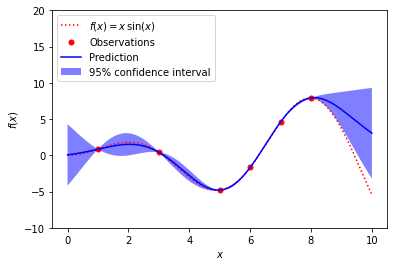

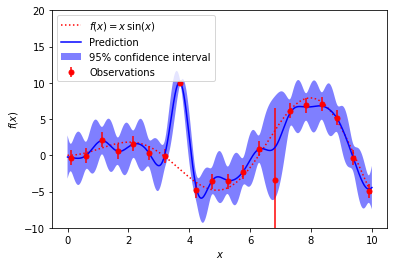

In [96]:
# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>s
# License: BSD 3 clause

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
# dy = 1e-3 + 1.0 * np.random.random(y.shape) * X.ravel()**2/5
dy = np.array([1., 1., 1., 1., 1., 1., 1., 0.1, 1, 1., 1., 1., 1., 10., 1., 1., 1.,
       1., 1., 1.])
noise = np.random.normal(0, dy)
y += noise

y[7]=10

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()